<a href="https://colab.research.google.com/github/ayarelif/DS-Unit-2-Applied-Modeling/blob/master/Elif_Ayar_of_assigment_234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apply Predictive Models

I want to evaluate four predictive models and choose one of them as a best predictive models based on accurancy score. Before starting any models, I will identified based line, then I will identifies train, val, and test targets and features sets.


In [ ]:
#Load the data first
import pandas as pd
import numpy as np

In [ ]:
train=pd.read_csv('train_set.csv')
val=pd.read_csv('val_set.csv')
test=pd.read_csv('test_set.csv')


In [24]:
train.columns

Index(['Unnamed: 0', 'Source', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'Side', 'City', 'State', 'Timezone', 'Airport_Code', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Sunrise_Sunset', 'Severity_of_accidents', 'year_recorded',
       'month_recorded', 'day_recorded', 'diff_hours', 'diff_minutes'],
      dtype='object')

In [25]:
# Let's set the train, val, and test datasets one more time.
Target=['Severity_of_accidents']
Features=['Source', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Side', 'City',
       'State', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset',
       'year_recorded', 'month_recorded',
       'day_recorded', 'diff_hours', 'diff_minutes']
X_train=train[Features]
y_train=train[Target]
X_val=val[Features]
y_val=val[Target]
X_test=test[Features]
y_test=test[Target]


In [26]:
#Shape
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((15304, 35), (15304, 1), (7653, 35), (7653, 1), (11595, 35), (11595, 1))

What is the baseline accuracy if we guessed the majority class for every prediction?

In [27]:
majority_class = y_train['Severity_of_accidents'].mode()[0]
y_pred = [majority_class] * len(y_train)

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.683742812336644

### LogisticRegression

Let's try first Logistic Regression

In [29]:
!pip install category_encoders==2.*

In [30]:
#Load the data
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [31]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on validation
print ('Validation Accruacy', pipeline.score(X_val, y_val))



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accruacy 0.7576113942244871


Accuracy Score is 0.7576113. This is better score than baseline score

#Decision Tree

Second, I want to apply decision tree

In [32]:
#Load the data
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf = 20,random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on validation
print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8131207527443806
Validation Accuracy 0.7300405069907225


That is interesting because accuracy score of validate set is smaller than lotistic regression's accurancy score.

In [34]:
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=True, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

TypeError: ignored

Decision Tree does not have a strong coefficent equation because of categorical type of data. Thus, in order to identify the importance of features, decision tree use the parameter .feature_importance_. This is one of the parameter we could use. I will apply other option below as well.

In [35]:
%matplotlib inline
 

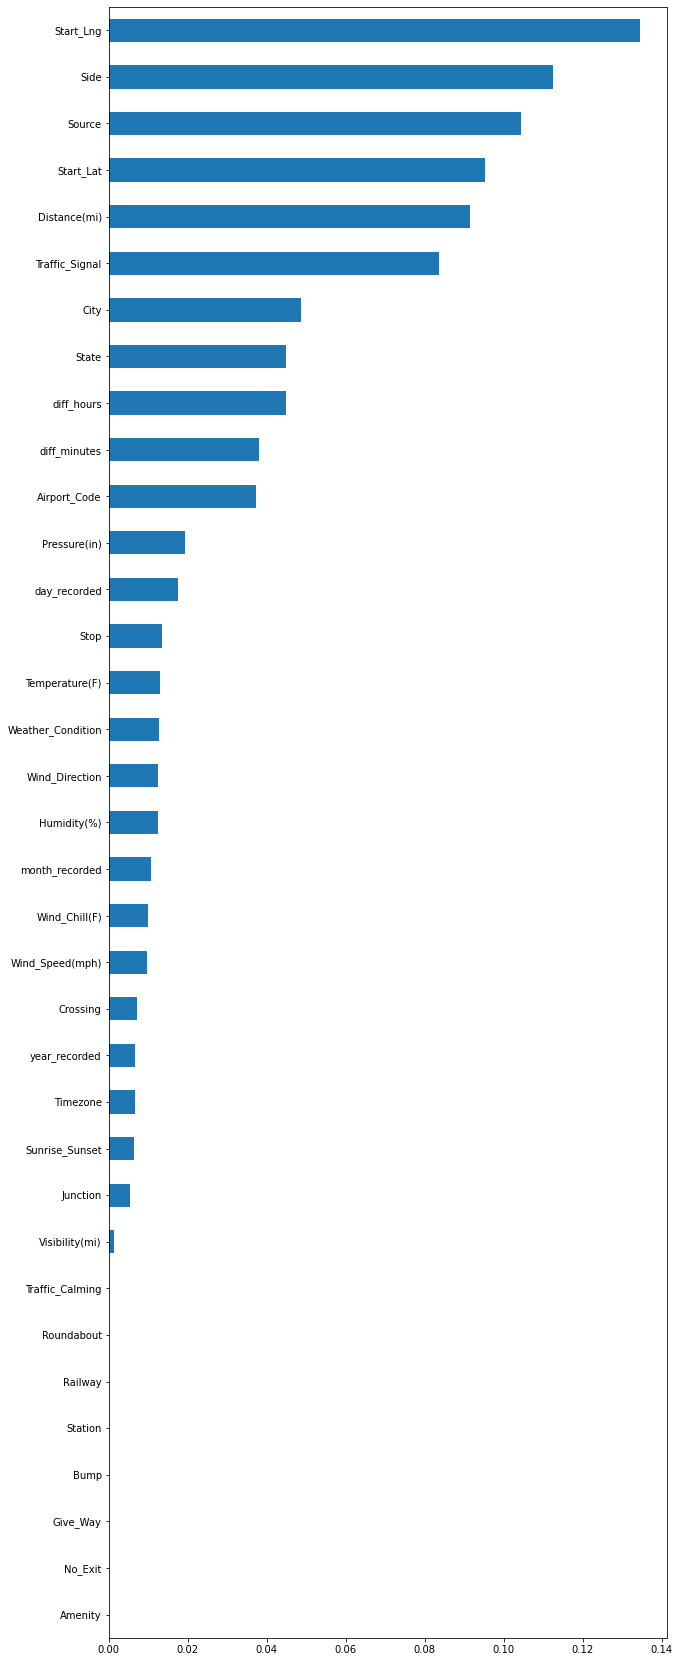

In [36]:
# Feature importance


import matplotlib.pyplot as plt

encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()

From the graph, we could see that most 5 importance featue are Start_Lng,side, source, start_lan, distance.

# Random Forest

In [37]:
# Load the random forest tools

%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

CPU times: user 8.72 ms, sys: 2.99 ms, total: 11.7 ms
Wall time: 27.8 ms


In [38]:
pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(n_estimators=50,random_state=100,n_jobs=-1)
)


In [39]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'City', 'State',
                                      'Timezone', 'Airport_Code',
                                      'Wind_Direction', 'Weather_Condition',
                                      'Sunrise_Sunset'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': MapQuest         1
Bing             2
MapQuest-Bing    3
NaN             -2
dtype: int64},...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                      

In [40]:
print('Validation Accuracy is ',pipeline.score(X_train,y_train)  )
print('Validation Accuracy is ',pipeline.score(X_val,y_val)  )

Validation Accuracy is  0.9998693152117094
Validation Accuracy is  0.7560433816803868


This score is better than decision tree, but less than Logistic Regression, 0.757611.

Thus, let's improve the score with hyperparameter optimization .randomsearchCV().

In [41]:
# I want to show permutation importance as well
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [42]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 4.5MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [43]:
permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=5,
    random_state=42 
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [44]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Amenity             -0.000157
Roundabout           0.000000
No_Exit              0.000000
Bump                 0.000000
Traffic_Calming      0.000000
Railway              0.000026
Give_Way             0.000052
Wind_Chill(F)        0.000131
Station              0.000131
Weather_Condition    0.001307
Visibility(mi)       0.001333
Stop                 0.001437
Wind_Speed(mph)      0.001699
Temperature(F)       0.001934
Humidity(%)          0.002378
Junction             0.002378
Wind_Direction       0.002849
day_recorded         0.003110
Sunrise_Sunset       0.003476
month_recorded       0.004338
Pressure(in)         0.005253
City                 0.005723
Crossing             0.005749
diff_hours           0.007344
Timezone             0.007605
year_recorded        0.008885
Airport_Code         0.011316
Distance(mi)         0.011446
diff_minutes         0.012649
State                0.013250
Start_Lat            0.015732
Source               0.019679
Traffic_Signal       0.019809
Side      

In [45]:
# 2. Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0210 ± 0.0027,Start_Lng
0.0209 ± 0.0022,Side
0.0198 ± 0.0024,Traffic_Signal
0.0197 ± 0.0048,Source
0.0157 ± 0.0042,Start_Lat
0.0132 ± 0.0047,State
0.0126 ± 0.0071,diff_minutes
0.0114 ± 0.0044,Distance(mi)
0.0113 ± 0.0039,Airport_Code
0.0089 ± 0.0037,year_recorded


Based on the permutation importance, some features are not have an impact on predictive modeling such as no_exit, Roundabpout and so on. If we give up the these features, model transforms faster and score are not going to e change. 

In [46]:
#Let's look at the shape one more time
X_train.shape

(15304, 35)

In [47]:
minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance 
features = X_train.columns[mask] 
X_train = X_train[features] 

In [48]:
 X_train.shape

(15304, 30)

In [49]:
# set the new features to other sets as well
X_val = X_val[features]
X_test = X_test[features]

In [50]:
 X_val.shape,X_test.shape

((7653, 30), (11595, 30))

In [55]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100,random_state=100,n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Validation Accuracy 0.7565660525284202


In [56]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7565660525284202


### RandomForest with hyperparameter optimization

In [57]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [58]:
# make pipeline

pipeline = make_pipeline(
     ce.OrdinalEncoder(), 
     SimpleImputer(), 
     RandomForestClassifier(random_state=42)
)


In [59]:
from scipy.stats import randint, uniform
hyperparam_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20,25,30,35,40,45,50, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

In [60]:
#RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
search=RandomizedSearchCV(
    pipeline,
    param_distributions=hyperparam_distributions,
    n_iter=3,
    cv=3,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

In [61]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   52.7s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [62]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 35, 'randomforestclassifier__max_features': 0.39630770875097543, 'randomforestclassifier__n_estimators': 200, 'simpleimputer__strategy': 'median'}
Cross-validation MAE -0.7571872172703319


Thus, cross validation is 0.757187. not good

### XGBoost

In [63]:
from xgboost import XGBClassifier 

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42,n_jobs=-1)
)

In [64]:
pipeline.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'City', 'State',
                                      'Timezone', 'Airport_Code',
                                      'Wind_Direction', 'Weather_Condition',
                                      'Sunrise_Sunset'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': MapQuest         1
Bing             2
MapQuest-Bing    3
NaN             -2
dtype: int64},...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0

In [65]:
print('Validation Accuracy is ',pipeline.score(X_train,y_train)  )
print('Validation Accuracy is ',pipeline.score(X_val,y_val)  )

Validation Accuracy is  0.7562728698379508
Validation Accuracy is  0.7404939239513916


In [66]:
#fit_transform on train, transform on val
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000, 
    max_depth=7,      
    learning_rate=0.5,  
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric=None,
          early_stopping_rounds=50) 
 

[0]	validation_0-error:0.256926	validation_1-error:0.281197
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	validation_0-error:0.253855	validation_1-error:0.279237
[2]	validation_0-error:0.236278	validation_1-error:0.269045
[3]	validation_0-error:0.225497	validation_1-error:0.264602
[4]	validation_0-error:0.222687	validation_1-error:0.26225
[5]	validation_0-error:0.211187	validation_1-error:0.253103
[6]	validation_0-error:0.203084	validation_1-error:0.253626
[7]	validation_0-error:0.191192	validation_1-error:0.251666
[8]	validation_0-error:0.187925	validation_1-error:0.251013
[9]	validation_0-error:0.183547	validation_1-error:0.248007
[10]	validation_0-error:0.17662	validation_1-error:0.247223
[11]	validation_0-error:0.169302	validation_1-error:0.249314
[12]	validation_0-error:0.158847	validation_1-error:0.253234
[13]	validation_0-error:0.154339	validation_1-error:0.251927
[14]	validation_0-error:0.15081	validation_1-error:0.251405
[15]	validation_0-error:0.149503	validation_1-error:0.247877
[16]	validation_0-error:0.14225	validation_1-error:0.242519
[17]	validation_0-error:0.137807	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

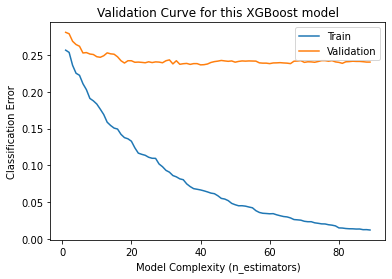

In [76]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
plt.legend();

I got better result compared to random forest model. Validation score is
1-0.236901=0.7630

---

